# Optimization Tutorial

Trey V. Wenger (c) October 2024

Here we demonstrate how to optimize the number of cloud components in a `EmissionAbsorptionModel` model.

In [1]:
# General imports    
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.16.2
bayes_spec version: 1.7.0
caribou_hi version: 1.2.0b1+0.gde16797.dirty


## Model Definition and Simulated Data

In [4]:
from bayes_spec import SpecData

# spectral axes definitions
emission_axis = np.linspace(-60.0, 60.0, 200)  # km s-1
absorption_axis = np.linspace(-30.0, 30.0, 100)  # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms_emission = 0.1 # K
rms_absorption = 0.01 # optical depth

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
emission = rms_emission * np.random.randn(len(emission_axis))
absorption = rms_absorption * np.random.randn(len(absorption_axis))

dummy_data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)"),
}

from caribou_hi import EmissionAbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = EmissionAbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    bg_temp = 3.77, # assumed background temperature (K)
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    ordered=False,  # do not assume optically-thin
)
model.add_likelihood()

# Evaluate likelihood for given model parameters
sim_params = {
    "log10_NHI": np.array([21.0, 19.5, 20.5]),
    "log10_depth": np.array([1.5, 0.5, 2.5]),
    "log10_pressure": np.array([3.5, 3.5, 3.0]),
    "velocity": np.array([5.0, 0.0, -5.0]),
    "log10_n_alpha": -6.5,
    "log10_larson_linewidth": 0.25,
    "larson_power": 0.33,
}

sim_params_emission = sim_params.copy()
sim_params_emission["baseline_emission_norm"] = np.array([0.0])

sim_params_absorption = sim_params.copy()
sim_params_absorption["baseline_absorption_norm"] = np.array([0.0])

emission = model.model["emission"].eval(sim_params_emission)
absorption = model.model["absorption"].eval(sim_params_absorption)

data = {
    "emission": SpecData(
        emission_axis,
        emission,
        rms_emission,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$T_B$ (K)"),
    "absorption": SpecData(
        absorption_axis,
        absorption,
        rms_absorption,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"1 - exp(-$\tau$)"),
}

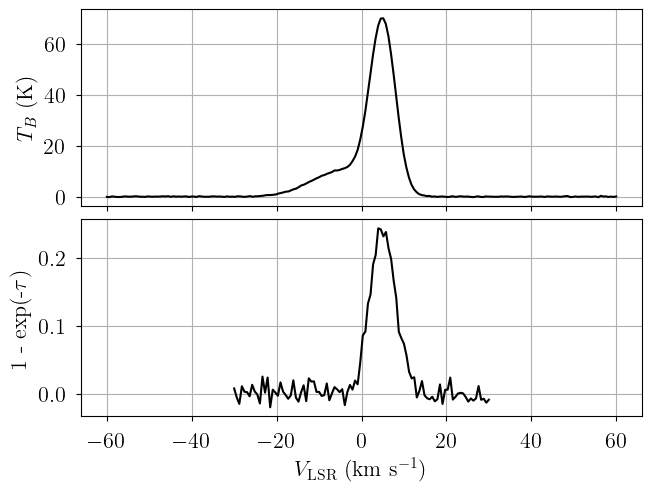

In [5]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained", sharex=True)
axes[0].plot(data["emission"].spectral, data["emission"].brightness, "k-")
axes[1].plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
axes[1].set_xlabel(data["emission"].xlabel)
axes[0].set_ylabel(data["emission"].ylabel)
_ = axes[1].set_ylabel(data["absorption"].ylabel)

## `Optimize`

We use the `Optimize` class for optimization.

In [6]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    EmissionAbsorptionModel,  # model definition
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=baseline_degree,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_log10_NHI=[20.0, 1.0],  # log10(NHI) prior mean and width (cm-2)
    prior_log10_depth=[1.0, 1.0],  # log10(depth) prior mean and width (pc)
    prior_log10_pressure=[3.0, 1.0],  # log10(pressure/k_B) prior mean and width (K cm-3)
    prior_velocity=[0.0, 5.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 1.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_log10_larson_linewidth=[0.2, 0.1],  # log10(larson_linewidth) prior mean and width (km s-1)
    prior_larson_power=[0.4, 0.1],  # mean and width of larson_power prior
    ordered=False,  # do not assume optically-thin
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [7]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model, and is then sampled with MCMC.

In [8]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, fit_kwargs=fit_kwargs)

Null hypothesis BIC = 4.144e+06
Approximating n_cloud = 1 posterior...


Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = 3.3271e+05


Output()

n_cloud = 1 BIC = 1.303e+05

Approximating n_cloud = 2 posterior...


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 2.7981e+05


Output()

n_cloud = 2 BIC = -4.763e+02

Approximating n_cloud = 3 posterior...


Output()

Convergence achieved at 8500
Interrupted at 8,499 [8%]: Average Loss = 2.1541e+05


Output()

n_cloud = 3 BIC = -7.760e+02

Approximating n_cloud = 4 posterior...


Output()

Convergence achieved at 8900
Interrupted at 8,899 [8%]: Average Loss = 1.9685e+05


Output()

n_cloud = 4 BIC = -6.467e+02

Approximating n_cloud = 5 posterior...


Output()

Convergence achieved at 9000
Interrupted at 8,999 [8%]: Average Loss = 1.9876e+05


Output()

n_cloud = 5 BIC = -8.203e+02

Sampling best model (n_cloud = 5)...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9000
Interrupted at 8,999 [8%]: Average Loss = 1.9876e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1501 seconds.


Adding log-likelihood to trace


Output()

There were 112 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.


The "best" model is saved in `opt.best_model`. Note that the variational inference algorithm has determined that the optimal number of clouds is `n_cloud=4` when, in fact, we generated these data with `n_cloud=3`. Then, no solutions for the `n_cloud=4` model were found with MCMC. Yikes!

Variational inference is only approximation and is ultimately sensitive to the tuning of the hyperparameters! In general, set `approx=False` to sample the posterior distributions of each model with MCMC.

In [9]:
fit_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 1e-2,
}
sample_kwargs = {
    "chains": 4,
    "cores": 4,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.8},
}
opt.optimize(bic_threshold=10.0, sample_kwargs=sample_kwargs, approx=False)

Null hypothesis BIC = 4.144e+06
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6700
Interrupted at 6,699 [6%]: Average Loss = 3.3271e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1087 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 1.291e+05

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 6500
Interrupted at 6,499 [6%]: Average Loss = 2.7981e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1099 seconds.


Adding log-likelihood to trace


Output()

There were 9 divergences in converged chains.
GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = -7.240e+02

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8500
Interrupted at 8,499 [8%]: Average Loss = 2.1541e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1124 seconds.


Adding log-likelihood to trace


Output()

There were 1 divergences in converged chains.
GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -9.068e+02

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 8900
Interrupted at 8,899 [8%]: Average Loss = 1.9685e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1365 seconds.


Adding log-likelihood to trace


Output()

GMM found 2 unique solutions
Solution 0: chains [0, 3]
Solution 1: chains [1, 2]
Label order mismatch in solution 0
Chain 0 order: [0 2 1 3]
Chain 3 order: [0 1 2 3]
Adopting (first) most common order: [0 1 2 3]
n_cloud = 4 solution = 0 BIC = -8.839e+02
n_cloud = 4 solution = 1 BIC = -8.839e+02

Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 9000
Interrupted at 8,999 [8%]: Average Loss = 1.9876e+05
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_emission_norm, baseline_absorption_norm, log10_NHI_norm, log10_depth_norm, log10_pressure_norm, velocity_norm, log10_n_alpha_norm, log10_larson_linewidth_norm, larson_power_norm]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1593 seconds.


Adding log-likelihood to trace


Output()

There were 112 divergences in converged chains.
No solution found!
0 of 4 chains appear converged.



In [12]:
opt.best_model.n_clouds

3

Sampling: [absorption, emission]


Output()

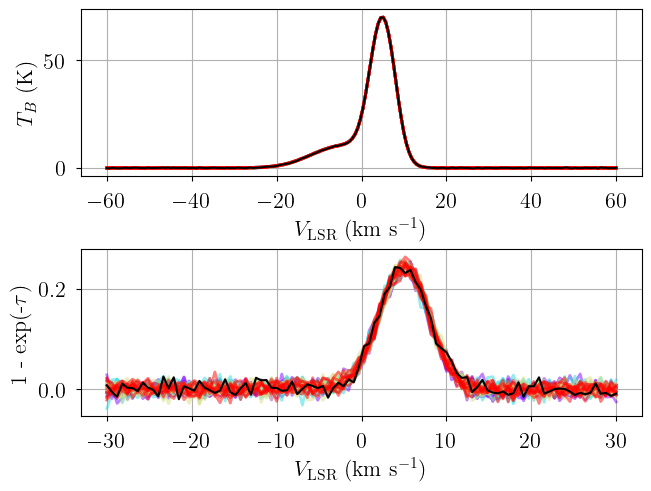

In [13]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(opt.best_model.data, posterior.posterior_predictive)